# ElasticNet

## Imports / Settings

In [ ]:
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.


In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import os
import wandb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from utils.evaluationUtility import evaluate_model, evaluate_classifier, calculate_metrics, analyze_all_results

In [35]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [36]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb._disable_jupyter = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\dario\_netrc


## Data

In [37]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")

train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

## Vectorization

In [38]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

## Training

In [39]:
classifier = SGDClassifier(
    penalty='elasticnet',
    loss='log_loss',
    l1_ratio=0.5,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=5
)

In [40]:
evaluate_classifier(
    classifier=classifier,
    classifier_name="SGD-Elasticnet",
    vectorizer=countVectorizer,
    vectorizer_name="CountVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="elasticNet"
)


Classifier: SGD-Elasticnet | Vectorizer: CountVectorizer
Validation Accuracy: 0.7677
Test Accuracy: 0.7683


f1,▁
precision,▁
recall,▁
f1,0.76383
precision,0.76928
recall,0.76833


In [41]:
evaluate_classifier(
    classifier=classifier,
    classifier_name="SGD-Elasticnet",
    vectorizer=tfidfVectorizer,
    vectorizer_name="TfIdfVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="elasticNet"
)


Classifier: SGD-Elasticnet | Vectorizer: TfIdfVectorizer
Validation Accuracy: 0.7522
Test Accuracy: 0.7522


f1,▁
precision,▁
recall,▁
f1,0.74745
precision,0.75215
recall,0.75217


## Hyperparameter Tuning

In [42]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SGDClassifier(
        loss='log_loss',
        early_stopping=True,
        max_iter=1000,
        random_state=42
    ))
])

param_grid = {
    'classifier__alpha': [1e-4, 1e-3, 1e-2],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__l1_ratio': [0.15, 0.5, 0.85]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(train_texts, train_labels)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(early_stopping=True,
                                                      loss='log_loss',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01],
                         'classifier__l1_ratio': [0.15, 0.5, 0.85],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='f1', verbose=2)

In [43]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'classifier__alpha': 0.0001, 'classifier__l1_ratio': 0.15, 'classifier__penalty': 'l2'}


In [44]:
best_model = grid.best_estimator_
evaluate_model(best_model, test_texts, test_labels)

f1,▁
precision,▁
recall,▁
f1,0.7604
precision,0.76441
recall,0.76437


(0.7644062737783706, 0.7643725416120358, 0.7603961937612632)

In [58]:
calculate_metrics(
    model=best_model,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    classifier_name="SGD-Elasticnet-Tuned",
    vectorizer_name="CountVectorizer",
    model_name="elasticNet"
)


Classifier: SGD-Elasticnet-Tuned | Vectorizer: CountVectorizer
Validation Accuracy: 0.7640
Test Accuracy: 0.7644


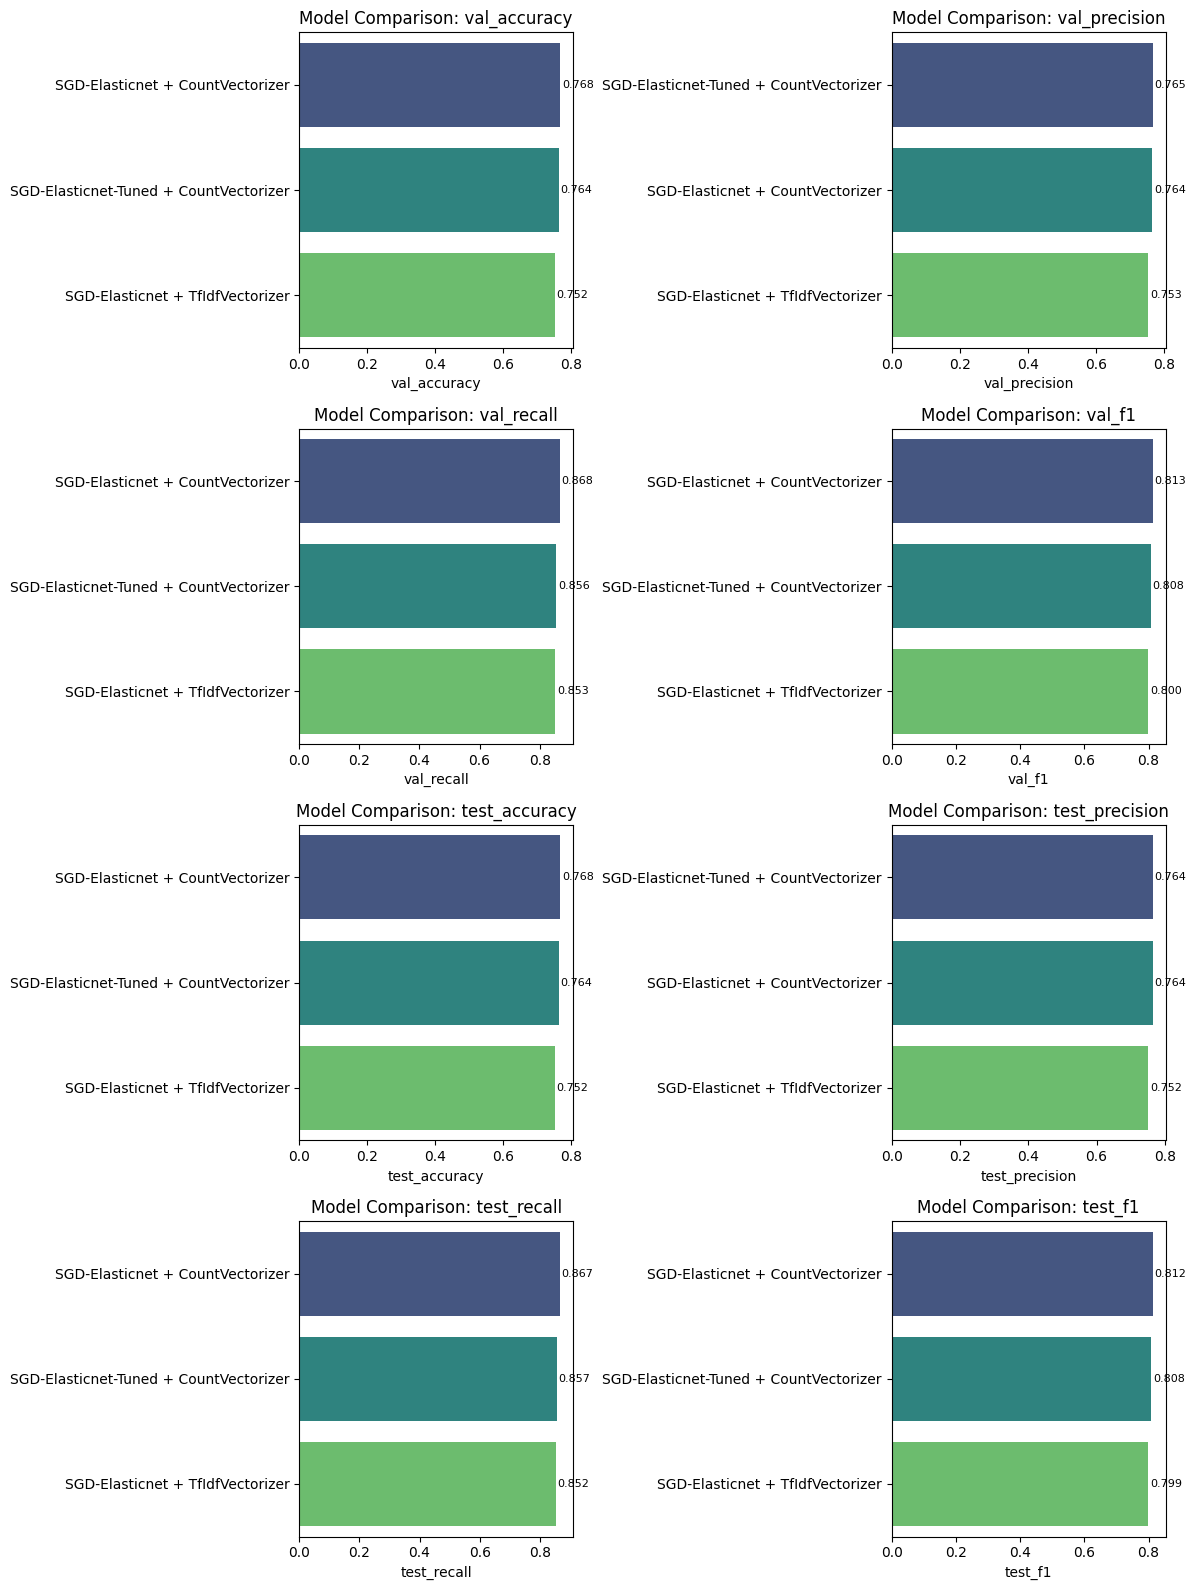

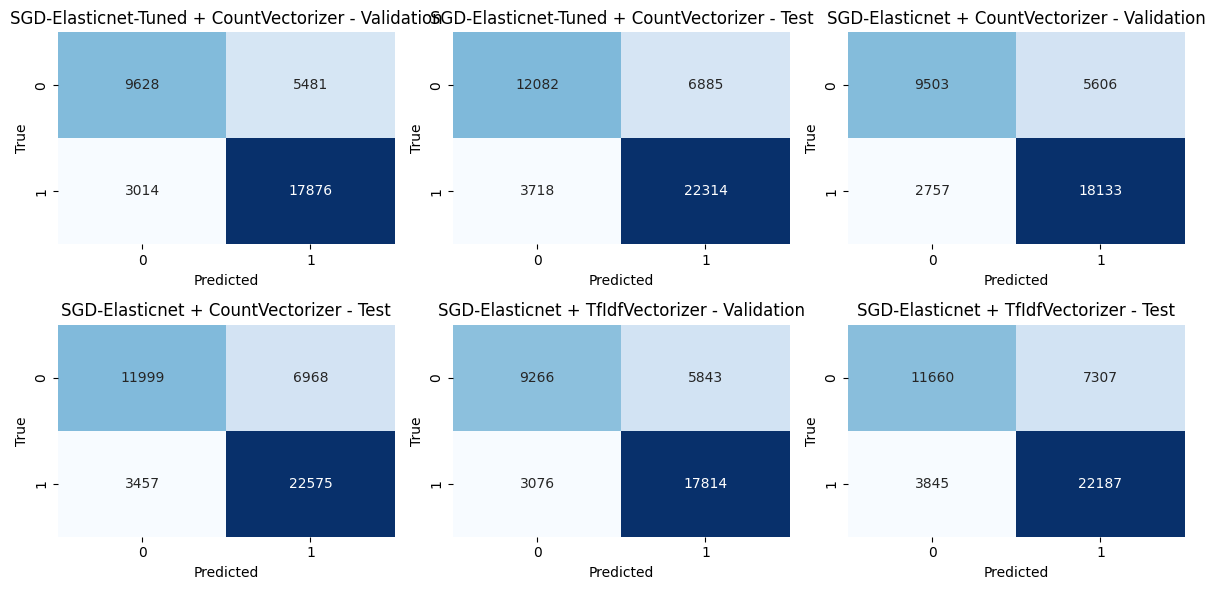

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,Classifier,Vectorizer,Validation Confusion,Test Confusion,Model
0,SGD-Elasticnet-Tuned,CountVectorizer,0.764021,0.765338,0.855720,0.808010,0.764373,0.764204,0.857176,0.808024,SGD-Elasticnet-Tuned,CountVectorizer,"[[9628, 5481], [3014, 17876]]","[[12082, 6885], [3718, 22314]]",SGD-Elasticnet-Tuned + CountVectorizer
1,SGD-Elasticnet,CountVectorizer,0.767688,0.763849,0.868023,0.812611,0.768328,0.764140,0.867202,0.812416,SGD-Elasticnet,CountVectorizer,"[[9503, 5606], [2757, 18133]]","[[11999, 6968], [3457, 22575]]",SGD-Elasticnet + CountVectorizer
2,SGD-Elasticnet,TfIdfVectorizer,0.752243,0.753012,0.852753,0.799784,0.752172,0.752255,0.852297,0.799157,SGD-Elasticnet,TfIdfVectorizer,"[[9266, 5843], [3076, 17814]]","[[11660, 7307], [3845, 22187]]",SGD-Elasticnet + TfIdfVectorizer


In [59]:
analyze_all_results(results_dir="executions/elasticNet")